In [ ]:
# ----------------------------------------------------------------------------
# BAGIAN 1: PERSIAPAN LINGKUNGAN (SETUP)
# ----------------------------------------------------------------------------
print("=" * 70)
print("BAGIAN 1: PERSIAPAN LINGKUNGAN")
print("=" * 70)

# Install PySpark
!pip install pyspark -q

print("\n✅ PySpark berhasil diinstal!")

# Import libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator

# Membuat Spark Session
spark = SparkSession.builder \
    .appName("Latihan_MLlib") \
    .getOrCreate()

print("✅ Spark Session berhasil dibuat!")
print(spark)
print()

BAGIAN 1: PERSIAPAN LINGKUNGAN

✅ PySpark berhasil diinstal!
✅ Spark Session berhasil dibuat!



In [ ]:
# ----------------------------------------------------------------------------
# BAGIAN 2: REGRESI LINIER (Prediksi Nilai)
# ----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("BAGIAN 2: LINEAR REGRESSION (PREDIKSI GAJI)")
print("=" * 70)

print("\n💡 SKENARIO:")
print("   Kita punya data karyawan (Pengalaman & Umur)")
print("   Goal: PREDIKSI GAJI berdasarkan 2 faktor tersebut")
print("\n📊 ANALOGI:")
print("   Semakin lama pengalaman → Gaji lebih tinggi")
print("   Semakin tua umur → Gaji lebih tinggi (asumsi: lebih senior)")

# Langkah 3: Membuat Dataset
print("\n" + "-" * 70)
print("LANGKAH 3: MEMBUAT DATASET KARYAWAN")
print("-" * 70)

# Data: (Pengalaman tahun, Umur, Gaji)
data_gaji = [
    (1.0, 20, 5000),
    (2.0, 22, 6000),
    (3.0, 25, 7000),
    (4.0, 26, 8500),
    (5.0, 30, 10000),
    (6.0, 31, 11500)
]

columns = ["pengalaman", "umur", "gaji"]
df_regresi = spark.createDataFrame(data_gaji, columns)

print("\n📋 Data Karyawan (Training Data):")
df_regresi.show()

# Langkah 4: Feature Engineering (Vector Assembler)
print("\n" + "-" * 70)
print("LANGKAH 4: VECTOR ASSEMBLER (Feature Engineering)")
print("-" * 70)

print("\n💡 MENGAPA PERLU VECTOR ASSEMBLER?")
print("   Spark MLlib butuh semua fitur dalam 1 KOLOM VEKTOR")
print("   Contoh:")
print("   SEBELUM: pengalaman=5, umur=30 (2 kolom terpisah)")
print("   SESUDAH: features=[5.0, 30.0] (1 kolom vektor)")

assembler = VectorAssembler(
    inputCols=["pengalaman", "umur"],
    outputCol="features"
)

# Transformasi data
data_siap_reg = assembler.transform(df_regresi).select("features", "gaji")

print("\n📊 Data dalam Format Vector:")
data_siap_reg.show(truncate=False)

# Langkah 5: Training & Prediksi
print("\n" + "-" * 70)
print("LANGKAH 5: TRAINING MODEL & PREDIKSI")
print("-" * 70)

# Bagi data: 70% training, 30% testing
train_data, test_data = data_siap_reg.randomSplit([0.7, 0.3], seed=42)

print(f"\n📊 Jumlah data training: {train_data.count()}")
print(f"📊 Jumlah data testing: {test_data.count()}")

# Inisialisasi & Training Model
lr = LinearRegression(featuresCol="features", labelCol="gaji")
model_lr = lr.fit(train_data)

print("\n✅ Model Linear Regression berhasil di-training!")

# Prediksi pada data testing
hasil_prediksi = model_lr.transform(test_data)

print("\n🎯 HASIL PREDIKSI GAJI:")
print("   (Bandingkan kolom 'gaji' dengan 'prediction')")
hasil_prediksi.select("features", "gaji", "prediction").show()

# Koefisien & Intercept
print("\n📐 PARAMETER MODEL:")
print(f"   Koefisien (slope): {model_lr.coefficients}")
print(f"   Intercept (bias): {model_lr.intercept:.2f}")

print("\n💡 INTERPRETASI:")
print(f"   Rumus: Gaji = {model_lr.intercept:.2f} + "
      f"{model_lr.coefficients[0]:.2f}×Pengalaman + "
      f"{model_lr.coefficients[1]:.2f}×Umur")

# Evaluasi Model
evaluator = RegressionEvaluator(labelCol="gaji", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(hasil_prediksi)
print(f"\n📊 RMSE (Root Mean Square Error): ${rmse:.2f}")
print("   (Semakin kecil RMSE, semakin bagus model)")


BAGIAN 2: LINEAR REGRESSION (PREDIKSI GAJI)

💡 SKENARIO:
   Kita punya data karyawan (Pengalaman & Umur)
   Goal: PREDIKSI GAJI berdasarkan 2 faktor tersebut

📊 ANALOGI:
   Semakin lama pengalaman → Gaji lebih tinggi
   Semakin tua umur → Gaji lebih tinggi (asumsi: lebih senior)

----------------------------------------------------------------------
LANGKAH 3: MEMBUAT DATASET KARYAWAN
----------------------------------------------------------------------

📋 Data Karyawan (Training Data):
+----------+----+-----+
|pengalaman|umur| gaji|
+----------+----+-----+
|       1.0|  20| 5000|
|       2.0|  22| 6000|
|       3.0|  25| 7000|
|       4.0|  26| 8500|
|       5.0|  30|10000|
|       6.0|  31|11500|
+----------+----+-----+


----------------------------------------------------------------------
LANGKAH 4: VECTOR ASSEMBLER (Feature Engineering)
----------------------------------------------------------------------

💡 MENGAPA PERLU VECTOR ASSEMBLER?
   Spark MLlib butuh semua fitur dala

In [ ]:
# ----------------------------------------------------------------------------
# BAGIAN 3: KLASIFIKASI (Logistic Regression)
# ----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("BAGIAN 3: LOGISTIC REGRESSION (PREDIKSI CHURN)")
print("=" * 70)

print("\n💡 SKENARIO:")
print("   Kita punya data pelanggan aplikasi streaming")
print("   Goal: PREDIKSI apakah pelanggan akan CHURN (berhenti langganan)")
print("\n📊 ANALOGI:")
print("   Jarang pakai app + banyak komplain → Kemungkinan CHURN tinggi")
print("   Sering pakai app + nol komplain → Kemungkinan LOYAL")

# Langkah 6: Persiapan Data Klasifikasi
print("\n" + "-" * 70)
print("LANGKAH 6: MEMBUAT DATASET CHURN")
print("-" * 70)

# Data: (Durasi Penggunaan/jam per hari, Jumlah Komplain, Label Churn)
# Label: 1 = Churn (Berhenti), 0 = Loyal (Tetap)
data_churn = [
    (2.0, 5, 1),   # Jarang pakai, banyak komplain → Churn
    (1.0, 4, 1),   # Sangat jarang, banyak komplain → Churn
    (10.0, 0, 0),  # Sering pakai, nol komplain → Loyal
    (12.0, 1, 0),  # Sering pakai, sedikit komplain → Loyal
    (3.0, 3, 1),   # Jarang pakai, komplain sedang → Churn
    (15.0, 0, 0),  # Sangat sering, nol komplain → Loyal
    (1.5, 6, 1),   # Sangat jarang, sangat banyak komplain → Churn
    (11.0, 1, 0)   # Sering pakai, komplain sedikit → Loyal
]

df_churn = spark.createDataFrame(data_churn, ["durasi", "komplain", "label"])

print("\n📋 Data Pelanggan:")
df_churn.show()

print("\n💡 PENJELASAN KOLOM:")
print("   - durasi: Jam pakai app per hari")
print("   - komplain: Jumlah komplain dalam 1 bulan")
print("   - label: 1 = Churn (Berhenti), 0 = Loyal (Tetap)")

# Vector Assembler
assembler_churn = VectorAssembler(
    inputCols=["durasi", "komplain"],
    outputCol="features"
)

data_siap_class = assembler_churn.transform(df_churn).select("features", "label")

print("\n📊 Data dalam Format Vector:")
data_siap_class.show(truncate=False)

# Langkah 7: Training & Evaluasi
print("\n" + "-" * 70)
print("LANGKAH 7: TRAINING MODEL LOGISTIC REGRESSION")
print("-" * 70)

# Training Model
log_reg = LogisticRegression(featuresCol="features", labelCol="label")
model_churn = log_reg.fit(data_siap_class)

print("\n✅ Model Logistic Regression berhasil di-training!")

# Prediksi
hasil_churn = model_churn.transform(data_siap_class)

print("\n🎯 HASIL PREDIKSI CHURN:")
print("   Bandingkan kolom 'label' (asli) vs 'prediction' (prediksi model)")
hasil_churn.select("features", "label", "prediction", "probability").show(truncate=False)

print("\n💡 PENJELASAN OUTPUT:")
print("   - features: Input (durasi, komplain)")
print("   - label: Label asli (0=Loyal, 1=Churn)")
print("   - prediction: Prediksi model (0 atau 1)")
print("   - probability: [Probabilitas Loyal, Probabilitas Churn]")

# Evaluasi Akurasi
evaluator_class = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)
accuracy = evaluator_class.evaluate(hasil_churn)

print(f"\n📊 AKURASI MODEL: {accuracy * 100:.2f}%")
print("   (Persentase prediksi yang benar)")


BAGIAN 3: LOGISTIC REGRESSION (PREDIKSI CHURN)

💡 SKENARIO:
   Kita punya data pelanggan aplikasi streaming
   Goal: PREDIKSI apakah pelanggan akan CHURN (berhenti langganan)

📊 ANALOGI:
   Jarang pakai app + banyak komplain → Kemungkinan CHURN tinggi
   Sering pakai app + nol komplain → Kemungkinan LOYAL

----------------------------------------------------------------------
LANGKAH 6: MEMBUAT DATASET CHURN
----------------------------------------------------------------------

📋 Data Pelanggan:
+------+--------+-----+
|durasi|komplain|label|
+------+--------+-----+
|   2.0|       5|    1|
|   1.0|       4|    1|
|  10.0|       0|    0|
|  12.0|       1|    0|
|   3.0|       3|    1|
|  15.0|       0|    0|
|   1.5|       6|    1|
|  11.0|       1|    0|
+------+--------+-----+


💡 PENJELASAN KOLOM:
   - durasi: Jam pakai app per hari
   - komplain: Jumlah komplain dalam 1 bulan
   - label: 1 = Churn (Berhenti), 0 = Loyal (Tetap)

📊 Data dalam Format Vector:
+----------+-----+
|featu


BAGIAN 4: K-MEANS CLUSTERING (SEGMENTASI CUSTOMER)

💡 SKENARIO:
   Kita punya data pengunjung mall (Pendapatan & Skor Belanja)
   Goal: KELOMPOKKAN customer otomatis tanpa label sebelumnya

📊 ANALOGI:
   Komputer akan cari pola sendiri & bagi jadi 3 kelompok:
   - Cluster 0: Mungkin 'Pendapatan Rendah'
   - Cluster 1: Mungkin 'Pendapatan Sedang'
   - Cluster 2: Mungkin 'Pendapatan Tinggi & Boros'

----------------------------------------------------------------------
LANGKAH 8: MEMBUAT DATASET MALL & TRAINING K-MEANS
----------------------------------------------------------------------

📋 Data Pengunjung Mall:
+----------+----+
|pendapatan|skor|
+----------+----+
|        15|  39|
|        16|  81|
|        17|   6|
|        18|  77|
|        19|  40|
|        50|  50|
|        55|  55|
|        60|  60|
|        52|  48|
|       100|  90|
|       110|  95|
|       120|  88|
|       105|  92|
+----------+----+


💡 PENJELASAN KOLOM:
   - pendapatan: Pendapatan tahunan (dalam juta rupi

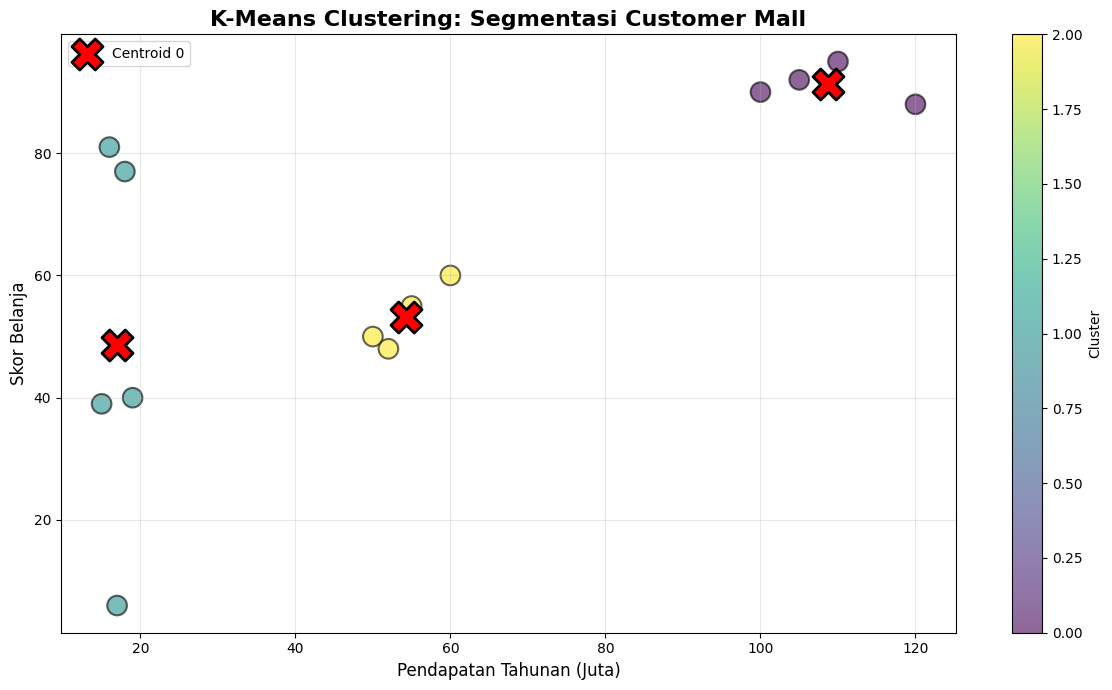


💡 CARA BACA GRAFIK:
   - Titik dengan warna sama = 1 cluster
   - X merah = Pusat cluster (centroid)
   - Customer dalam 1 cluster punya karakteristik mirip


In [ ]:
# ----------------------------------------------------------------------------
# BAGIAN 4: CLUSTERING (K-Means)
# ----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("BAGIAN 4: K-MEANS CLUSTERING (SEGMENTASI CUSTOMER)")
print("=" * 70)

print("\n💡 SKENARIO:")
print("   Kita punya data pengunjung mall (Pendapatan & Skor Belanja)")
print("   Goal: KELOMPOKKAN customer otomatis tanpa label sebelumnya")
print("\n📊 ANALOGI:")
print("   Komputer akan cari pola sendiri & bagi jadi 3 kelompok:")
print("   - Cluster 0: Mungkin 'Pendapatan Rendah'")
print("   - Cluster 1: Mungkin 'Pendapatan Sedang'")
print("   - Cluster 2: Mungkin 'Pendapatan Tinggi & Boros'")

# Langkah 8: Persiapan Data & Model
print("\n" + "-" * 70)
print("LANGKAH 8: MEMBUAT DATASET MALL & TRAINING K-MEANS")
print("-" * 70)

# Data: (Pendapatan Tahunan dalam juta, Skor Belanja 0-100)
data_mall = [
    (15, 39), (16, 81), (17, 6), (18, 77), (19, 40),  # Grup Pendapatan Rendah
    (50, 50), (55, 55), (60, 60), (52, 48),           # Grup Pendapatan Sedang
    (100, 90), (110, 95), (120, 88), (105, 92)        # Grup Kaya & Boros
]

df_mall = spark.createDataFrame(data_mall, ["pendapatan", "skor"])

print("\n📋 Data Pengunjung Mall:")
df_mall.show()

print("\n💡 PENJELASAN KOLOM:")
print("   - pendapatan: Pendapatan tahunan (dalam juta rupiah)")
print("   - skor: Skor belanja (0-100, semakin tinggi semakin sering belanja)")

# Vector Assembler (Hanya fitur, TANPA label!)
assembler_cluster = VectorAssembler(
    inputCols=["pendapatan", "skor"],
    outputCol="features"
)
data_siap_cluster = assembler_cluster.transform(df_mall)

print("\n📊 Data dalam Format Vector:")
data_siap_cluster.show()

# Training K-Means (K=3 artinya mau bagi jadi 3 kelompok)
print("\n🔄 Training K-Means dengan K=3 (3 cluster)...")
kmeans = KMeans().setK(3).setSeed(1)
model_km = kmeans.fit(data_siap_cluster)

print("✅ Model K-Means berhasil di-training!")

# Prediksi
prediksi_cluster = model_km.transform(data_siap_cluster)

print("\n🎯 HASIL CLUSTERING:")
print("   Kolom 'prediction' = Nomor Cluster (0, 1, atau 2)")
prediksi_cluster.show()

# Langkah 9: Analisis Pusat Cluster
print("\n" + "-" * 70)
print("LANGKAH 9: ANALISIS PUSAT CLUSTER (CENTROIDS)")
print("-" * 70)

print("\n💡 CENTROIDS = Titik tengah dari setiap cluster")
print("   Bisa dipakai untuk karakterisasi setiap kelompok")

centers = model_km.clusterCenters()

print("\n📍 PUSAT CLUSTER:")
for i, center in enumerate(centers):
    print(f"\n   Cluster {i}:")
    print(f"      - Pendapatan rata-rata: {center[0]:.1f} juta")
    print(f"      - Skor belanja rata-rata: {center[1]:.1f}")

    # Interpretasi
    if center[0] < 30:
        print(f"      → INTERPRETASI: Pendapatan RENDAH")
    elif center[0] < 70:
        print(f"      → INTERPRETASI: Pendapatan SEDANG")
    else:
        print(f"      → INTERPRETASI: Pendapatan TINGGI")

# Visualisasi Clustering (konversi ke Pandas untuk plotting)
print("\n📊 VISUALISASI CLUSTERING...")

import matplotlib.pyplot as plt
import pandas as pd

# Konversi ke Pandas
pdf_cluster = prediksi_cluster.select("pendapatan", "skor", "prediction").toPandas()

plt.figure(figsize=(12, 7))
scatter = plt.scatter(
    pdf_cluster['pendapatan'],
    pdf_cluster['skor'],
    c=pdf_cluster['prediction'],
    cmap='viridis',
    s=200,
    alpha=0.6,
    edgecolors='black',
    linewidth=1.5
)

# Plot centroids
for i, center in enumerate(centers):
    plt.scatter(center[0], center[1],
                marker='X', s=500, c='red',
                edgecolors='black', linewidth=2,
                label=f'Centroid {i}' if i == 0 else '')

plt.title('K-Means Clustering: Segmentasi Customer Mall', fontsize=16, fontweight='bold')
plt.xlabel('Pendapatan Tahunan (Juta)', fontsize=12)
plt.ylabel('Skor Belanja', fontsize=12)
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 CARA BACA GRAFIK:")
print("   - Titik dengan warna sama = 1 cluster")
print("   - X merah = Pusat cluster (centroid)")
print("   - Customer dalam 1 cluster punya karakteristik mirip")


BAGIAN 5: TUGAS LATIHAN

📝 TUGAS 1: Prediksi Gaji untuk Data Baru
----------------------------------------------------------------------

💡 SKENARIO:
   Ada karyawan baru: Pengalaman=10 tahun, Umur=40
   Berapa prediksi gajinya?

📋 Data dengan Karyawan Baru:
+----------+----+-----+
|pengalaman|umur| gaji|
+----------+----+-----+
|       1.0|  20| 5000|
|       2.0|  22| 6000|
|       3.0|  25| 7000|
|       4.0|  26| 8500|
|       5.0|  30|10000|
|       6.0|  31|11500|
|      10.0|  40| NULL|
+----------+----+-----+


🎯 HASIL PREDIKSI (Termasuk Data Baru):
+-----------+-----+------------------+
|   features| gaji|        prediction|
+-----------+-----+------------------+
| [1.0,20.0]| 5000| 4712.500000000006|
| [2.0,22.0]| 6000|  6037.49999999996|
| [3.0,25.0]| 7000| 7325.000000000075|
| [4.0,26.0]| 8500| 8687.499999999867|
| [5.0,30.0]|10000| 9937.500000000146|
| [6.0,31.0]|11500|11299.999999999936|
|[10.0,40.0]| NULL|16562.499999999913|
+-----------+-----+------------------+


✅ JA

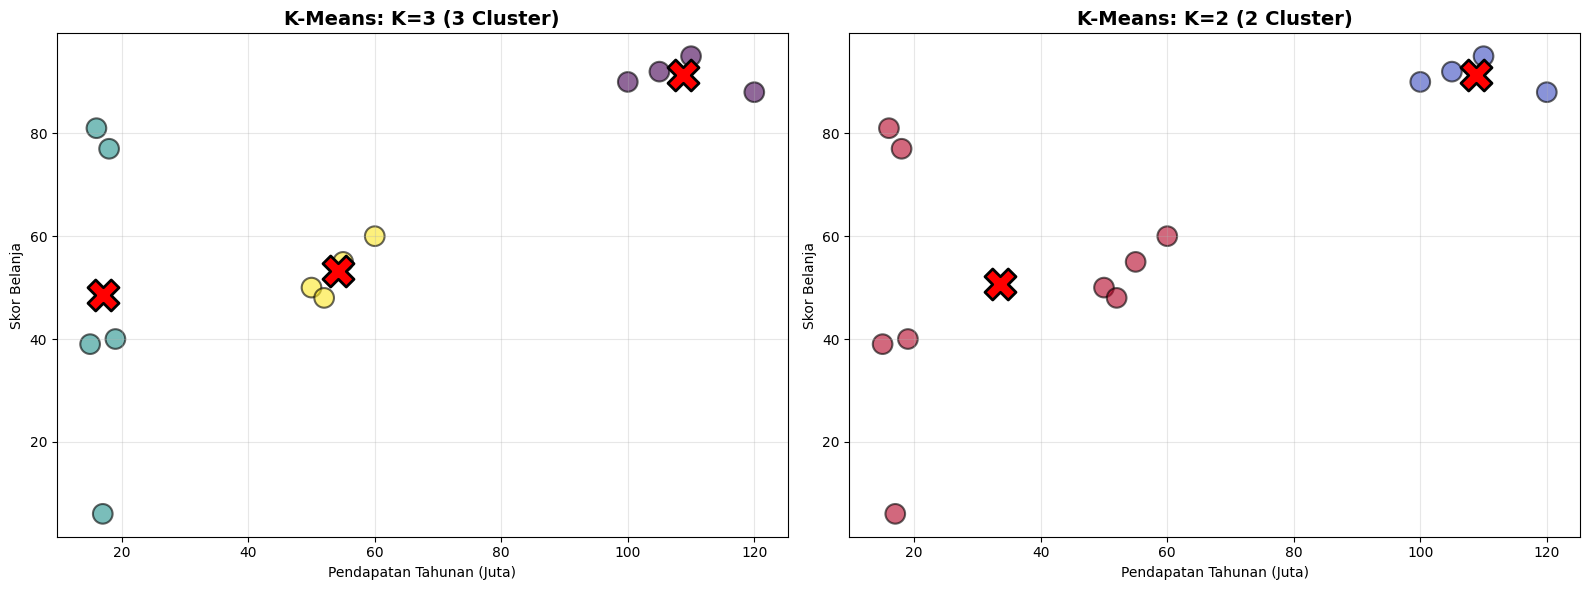


✅ JAWABAN TUGAS 2:
   Dengan K=2, data terbagi menjadi:
   - Cluster 0: Pendapatan RENDAH (< 50 juta)
   - Cluster 1: Pendapatan TINGGI (≥ 50 juta)

💡 KESIMPULAN:
   Ya, dengan K=2 data terbagi lebih sederhana jadi 'Kaya' vs 'Miskin'
   Tapi kurang detail dibanding K=3 yang bisa bedakan 'Sedang'


In [ ]:
# ----------------------------------------------------------------------------
# BAGIAN 5: TUGAS LATIHAN
# ----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("BAGIAN 5: TUGAS LATIHAN")
print("=" * 70)

# TUGAS 1: Tambah Data Baru & Prediksi Gaji
print("\n📝 TUGAS 1: Prediksi Gaji untuk Data Baru")
print("-" * 70)

print("\n💡 SKENARIO:")
print("   Ada karyawan baru: Pengalaman=10 tahun, Umur=40")
print("   Berapa prediksi gajinya?")

# Tambah data baru
data_baru_gaji = [
    (1.0, 20, 5000),
    (2.0, 22, 6000),
    (3.0, 25, 7000),
    (4.0, 26, 8500),
    (5.0, 30, 10000),
    (6.0, 31, 11500),
    (10.0, 40, None)  # Data baru untuk diprediksi
]

df_regresi_baru = spark.createDataFrame(data_baru_gaji, columns)

print("\n📋 Data dengan Karyawan Baru:")
df_regresi_baru.show()

# Vector Assembler
data_siap_reg_baru = assembler.transform(df_regresi_baru).select("features", "gaji")

# Prediksi (train pakai 6 data pertama, prediksi semua)
train_data_baru = data_siap_reg_baru.filter(df_regresi_baru.gaji.isNotNull())
model_lr_baru = lr.fit(train_data_baru)
hasil_prediksi_baru = model_lr_baru.transform(data_siap_reg_baru)

print("\n🎯 HASIL PREDIKSI (Termasuk Data Baru):")
hasil_prediksi_baru.select("features", "gaji", "prediction").show()

# Ambil prediksi untuk data baru (baris terakhir)
prediksi_gaji_baru = hasil_prediksi_baru.filter(hasil_prediksi_baru.gaji.isNull()) \
    .select("prediction").collect()[0][0]

print(f"\n✅ JAWABAN TUGAS 1:")
print(f"   Karyawan dengan Pengalaman=10 tahun & Umur=40")
print(f"   Prediksi Gaji: ${prediksi_gaji_baru:,.2f}")

# TUGAS 2: Ubah K-Means jadi K=2
print("\n" + "=" * 70)
print("📝 TUGAS 2: K-Means dengan K=2 (2 Cluster)")
print("-" * 70)

print("\n💡 SKENARIO:")
print("   Ubah dari 3 cluster jadi 2 cluster")
print("   Apakah datanya terbagi jadi 'Kaya' dan 'Miskin' saja?")

# Training K-Means dengan K=2
print("\n🔄 Training K-Means dengan K=2...")
kmeans_2 = KMeans().setK(2).setSeed(1)
model_km_2 = kmeans_2.fit(data_siap_cluster)

print("✅ Model K-Means (K=2) berhasil di-training!")

# Prediksi
prediksi_cluster_2 = model_km_2.transform(data_siap_cluster)

print("\n🎯 HASIL CLUSTERING (K=2):")
prediksi_cluster_2.show()

# Analisis Pusat Cluster
centers_2 = model_km_2.clusterCenters()

print("\n📍 PUSAT CLUSTER (K=2):")
for i, center in enumerate(centers_2):
    print(f"\n   Cluster {i}:")
    print(f"      - Pendapatan rata-rata: {center[0]:.1f} juta")
    print(f"      - Skor belanja rata-rata: {center[1]:.1f}")

    # Interpretasi
    if center[0] < 50:
        print(f"      → INTERPRETASI: Kelompok PENDAPATAN RENDAH")
    else:
        print(f"      → INTERPRETASI: Kelompok PENDAPATAN TINGGI")

# Visualisasi K=2
print("\n📊 VISUALISASI CLUSTERING (K=2)...")

pdf_cluster_2 = prediksi_cluster_2.select("pendapatan", "skor", "prediction").toPandas()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot K=3 (kiri)
axes[0].scatter(
    pdf_cluster['pendapatan'],
    pdf_cluster['skor'],
    c=pdf_cluster['prediction'],
    cmap='viridis',
    s=200,
    alpha=0.6,
    edgecolors='black',
    linewidth=1.5
)
for center in centers:
    axes[0].scatter(center[0], center[1], marker='X', s=500, c='red',
                    edgecolors='black', linewidth=2)
axes[0].set_title('K-Means: K=3 (3 Cluster)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Pendapatan Tahunan (Juta)')
axes[0].set_ylabel('Skor Belanja')
axes[0].grid(alpha=0.3)

# Plot K=2 (kanan)
axes[1].scatter(
    pdf_cluster_2['pendapatan'],
    pdf_cluster_2['skor'],
    c=pdf_cluster_2['prediction'],
    cmap='coolwarm',
    s=200,
    alpha=0.6,
    edgecolors='black',
    linewidth=1.5
)
for center in centers_2:
    axes[1].scatter(center[0], center[1], marker='X', s=500, c='red',
                    edgecolors='black', linewidth=2)
axes[1].set_title('K-Means: K=2 (2 Cluster)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Pendapatan Tahunan (Juta)')
axes[1].set_ylabel('Skor Belanja')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ JAWABAN TUGAS 2:")
print("   Dengan K=2, data terbagi menjadi:")
print("   - Cluster 0: Pendapatan RENDAH (< 50 juta)")
print("   - Cluster 1: Pendapatan TINGGI (≥ 50 juta)")
print("\n💡 KESIMPULAN:")
print("   Ya, dengan K=2 data terbagi lebih sederhana jadi 'Kaya' vs 'Miskin'")
print("   Tapi kurang detail dibanding K=3 yang bisa bedakan 'Sedang'")